# Predicting Temperature

In this exercise, we'll work with historical temperature data from the Szeged, Hungary area. The dataset we'll use is a Postgres database version of [this dataset from Kaggle](https://www.kaggle.com/budincsevity/szeged-weather/home). 


## Load the dataset from Thinkful's database

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# Use the connection to extract SQL data
weather_df = pd.read_sql_query('SELECT * FROM weatherinszeged', con=engine)

#Close the connection after query is complete
engine.dispose()

## Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.

In [3]:
target_var = 'temperature'
feature_set = ['humidity', 'windspeed', 'windbearing', 'pressure']

#Using scikit-learn LinearRegression():
from sklearn import linear_model

# X is the feature set 
X = weather_df[feature_set]
# Y is the target variable
Y = weather_df['temperature']

# We create a LinearRegression model object from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.926438185286


## Check if the model meets the Gauss-Markov Conditions

### Assumption One: Linearity of the Model in its Coefficients


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.9264381340472


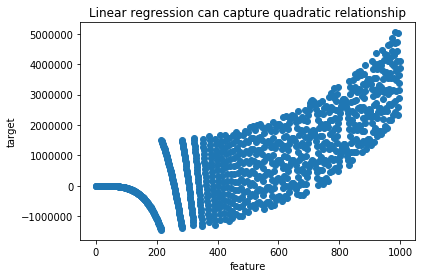

In [8]:
df = pd.DataFrame()

# Data from 0 to 999
df["X"] = np.arange(0,1000,1)
# Take the square of X
df["X_sq"] = df["X"]**2
# Take the cube of X
df["X_cub"] = df["X"]**3
# Take the 4th power of X
df["X_quad"] = df["X"]**4

# Equation: Y = Intercept + Coeff[0]*X + Coeff[1]*X^2 + Coeff[2]*X^3 + Coeff[3]*X^4
df["Y"] = lrm.intercept_ + lrm.coef_[0]*df["X"] + lrm.coef_[1]*df["X_sq"] + lrm.coef_[2]*df["X_cub"] + lrm.coef_[3]*df["X_quad"]

# Fit a linear regression where target is Y and features are X, X^2, X^3, and X^4
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df[["X","X_sq","X_cub","X_quad"]],df["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df[["X","X_sq","X_cub","X_quad"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

### Assumption Two: Error Term should be Zero on Average

In [10]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the weather model is: {}".format(np.mean(errors)))

Mean of the errors in the weather model is: -7.8414000283952e-15


This value is very close to zero, so this assumption holds true.

### Assumption Three: Homoscedasticity

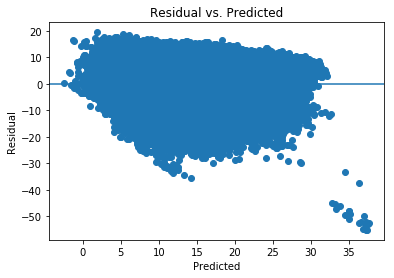

In [11]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [12]:
#Use Bartlett and Levene tests to check homoscedasticity
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


Therefore, we reject the null and conclude that our errors are heteroscedastic (not homoscedastic).

### Assumption Four: Low Multicollinearity

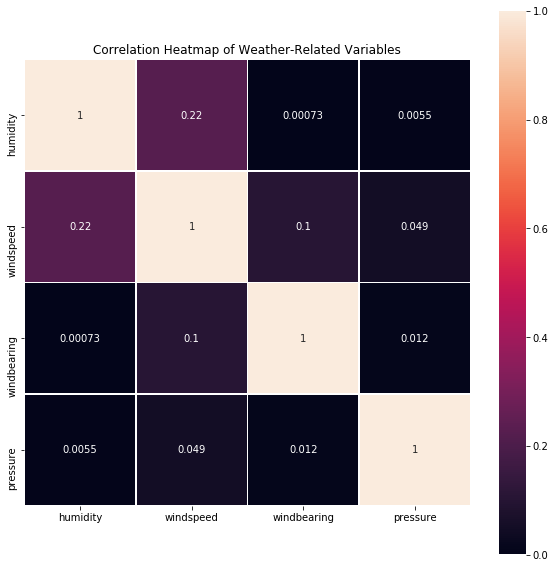

,humidity,windspeed,windbearing,pressure
humidity,1.000000,-0.224951,0.000735,0.005454
windspeed,-0.224951,1.000000,0.103822,-0.049263
windbearing,0.000735,0.103822,1.000000,-0.011651
pressure,0.005454,-0.049263,-0.011651,1.000000


In [20]:
#Compare the continuous variables and their correlations via a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(abs(weather_df[feature_set].corr()), square=True, linewidths=.5, annot=True)
plt.title('Correlation Heatmap of Weather-Related Variables')
plt.show()

weather_df[feature_set].corr()

### Assumption Five: Error Terms Should be Uncorrelated with One Another

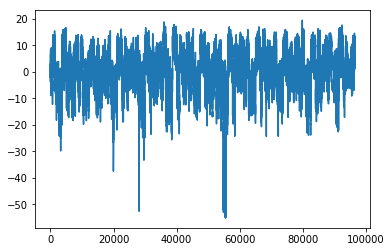

In [13]:
plt.plot(errors)
plt.show()

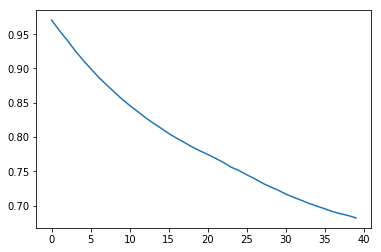

In [14]:
#Double-check with autocorrelation function
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

### Assumption Six: Features Shouldn't be Correlated with Errors

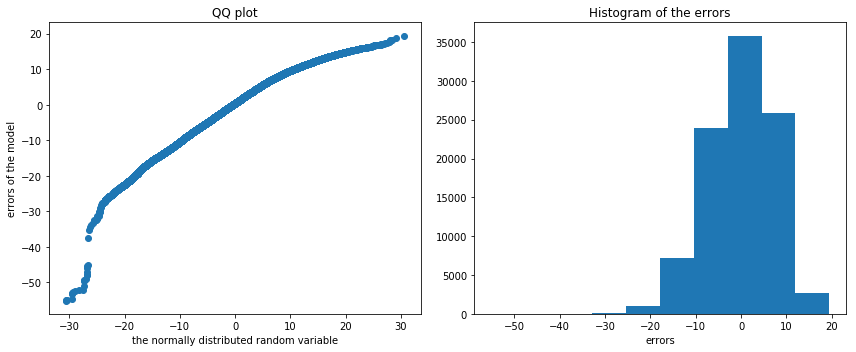

In [15]:
#Use histogram and QQ plot
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [16]:
#Visually, they look approximately normal, but not quite there
#Double-check with Jarque-Bera and Normality tests

from scipy.stats import jarque_bera
from scipy.stats import normaltest
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252489 and p value is 0.0
Normality test statistics is 3375.432307699663 and p value is 0.0


Both tests result in a p-value of 0, leading us to conclude that the errors are not normally distributed. 

## Conclusions:
This model passes 4 out of the 6 assumptions tested. However, it does not pass the homescedasticity test, nor does it show that the errors are uncorrelated to each other. To solve our homoscedasticity issue, we may have to remove outliers in the data, or include other variables that were previously ommitted from the model. The issue with error correlations could also be caused by the ommission of a necessary variable, so we should revisit our list of possible features and decide which additional ones to include when revisiting this model.